#### Notebook to Explore data

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn                   import linear_model, ensemble, preprocessing
from sklearn.model_selection   import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics           import r2_score, mean_squared_error, accuracy_score
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.naive_bayes       import MultinomialNB, GaussianNB

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 6
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
sns.set_style("whitegrid")

#### Reading the data

In [94]:
covid_df = pd.read_csv('data/covid_nsw_data.csv', parse_dates=['notification_date'])
income_df = pd.read_csv('data/income_data.csv', index_col=['Postcode'])
opal_df = pd.read_csv('data/opal_patronage_data.csv', parse_dates=['trip_origin_date'])

In [95]:
# Changing header names for dataframes
covid_headers = ['date', 'postcode', 'source', 'health_district', 'health_district_name', 'local_gov_code', 'local_gov_name']
opal_headers = ['date', 'mode_type', 'region', 'tap_hour', 'tap_on', 'tap_off']

covid_df.columns = covid_headers
opal_df.columns = opal_headers

In [96]:
#take columns that are needed and update dataframes
covid_df = covid_df[['date', 'postcode', 'source', 'health_district_name', 'local_gov_name']]
opal_df = opal_df[['date', 'mode_type', 'region','tap_on', 'tap_off']]

In [97]:
opal_df.head()

,date,mode_type,region,tap_on,tap_off
0,2020-01-01,Bus,Chatswood,<50,<50
1,2020-01-01,Bus,Macquarie Park,<50,<50
2,2020-01-01,Bus,Newcastle and surrounds,<50,<50
3,2020-01-01,Bus,North Sydney,700,100
4,2020-01-01,Bus,Other,4500,3200


#### Checking for null values:

In [98]:
opal_df.isnull().sum()

date         0
mode_type    0
region       0
tap_on       0
tap_off      0
dtype: int64

In [99]:
covid_df.isnull().sum()

date                      0
postcode                306
source                    0
health_district_name    312
local_gov_name          312
dtype: int64

#### Converting the <50 in Opal data to 50

In [100]:
opal_df["tap_on"].replace({"<50": "50"}, inplace=True)
opal_df["tap_on"] = opal_df["tap_on"].astype(int)
opal_df["tap_off"].replace({"<50": "50"}, inplace=True)
opal_df["tap_off"] = opal_df["tap_off"].astype(int)
opal_df.head()

,date,mode_type,region,tap_on,tap_off
0,2020-01-01,Bus,Chatswood,50,50
1,2020-01-01,Bus,Macquarie Park,50,50
2,2020-01-01,Bus,Newcastle and surrounds,50,50
3,2020-01-01,Bus,North Sydney,700,100
4,2020-01-01,Bus,Other,4500,3200


#### Isolating only the local cases in Covid DF

In [101]:
covid_df['source'].unique()

array(['Overseas', 'Locally acquired - source not identified',
       'Locally acquired - contact of a confirmed case and/or in a known cluster',
       'Interstate'], dtype=object)

In [102]:
covid_df = covid_df[covid_df.source != 'Overseas']
covid_df['source'].unique()

array(['Locally acquired - source not identified',
       'Locally acquired - contact of a confirmed case and/or in a known cluster',
       'Interstate'], dtype=object)

#### Tap on vs date line graph:

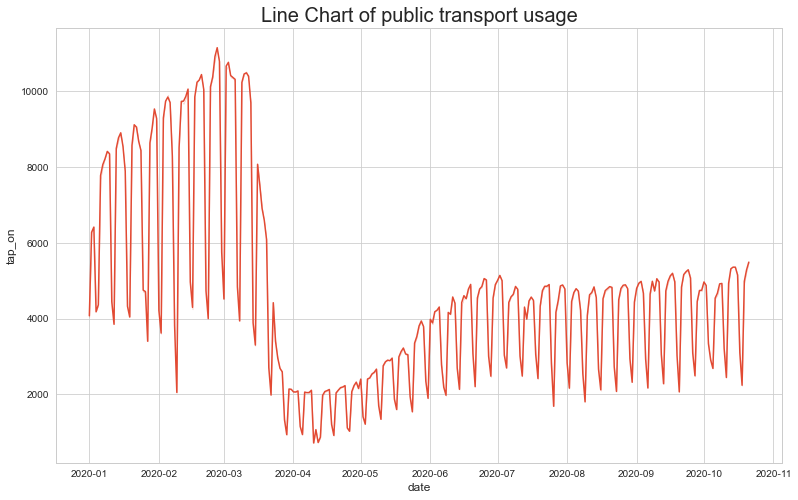

In [103]:
plt.figure(figsize=(13,8))
plt.title("Line Chart of public transport usage", fontsize=20)
sns.lineplot(x='date', y='tap_on',data=opal_df, sort=False,ci=False) 
plt.show()

#### Drawing a line chart to comapre bus and train usage

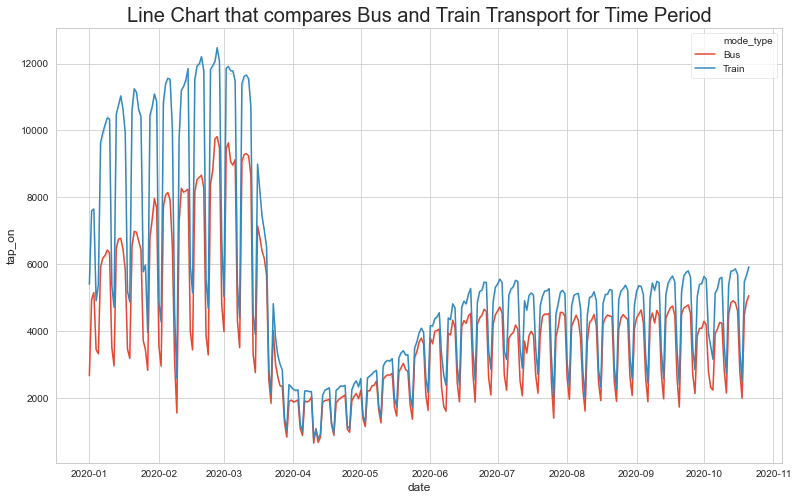

In [42]:
plt.figure(figsize=(13,8))
plt.title("Line Chart that compares Bus and Train Transport for Time Period", fontsize=20)
sns.lineplot(x='date', y='tap_on',data=opal_df, hue='mode_type',sort=False,ci=False) 
plt.show()

In [104]:
mask1=opal_df['mode_type'].isin(['Bus'])
mask2=opal_df['mode_type'].isin(['Train'])
opal_1=opal_df[mask1]
opal_2=opal_df[mask2]

opal_1['Mean_bus'] = opal_1['tap_on'].groupby(opal_1['date']).transform('mean')
opal_2['Mean_train'] = opal_2['tap_on'].groupby(opal_2['date']).transform('mean')

opal_1_new=opal_1[['date','Mean_bus']]
opal_1_new.set_index("date", inplace = True)
opal_1_new = opal_1_new.drop_duplicates()
opal_2_new=opal_2[['date','Mean_train']]
opal_2_new.set_index("date", inplace = True)
opal_2_new = opal_2_new.drop_duplicates()

opal_mix=pd.concat([opal_1_new, opal_2_new], axis=1)
opal_mix['Difference']=opal_mix['Mean_train']-opal_mix['Mean_bus']
opal_mix['Percentage_Change']=((opal_mix['Difference'])/opal_mix['Mean_bus'])*100 #calculates percentage change in train usage compared to bus usage
opal_mix.head()

,Mean_bus,Mean_train,Difference,Percentage_Change
date,,,,
2020-01-01,2665.929204,5403.333333,2737.404130,102.681051
2020-01-02,4946.304348,7598.922414,2652.618066,53.628282
2020-01-03,5151.521739,7653.404255,2501.882516,48.565893
2020-01-04,3449.137931,4907.510730,1458.372799,42.282241
2020-01-05,3325.438596,5386.422414,2060.983817,61.976300


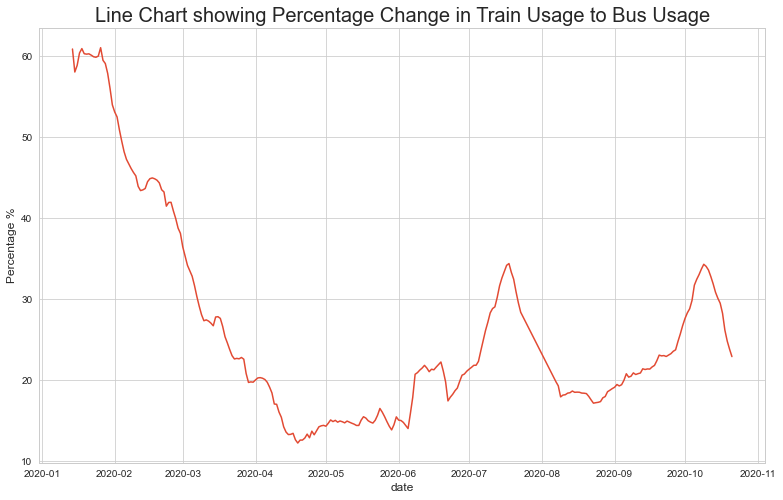

In [105]:
plt.figure(figsize=(13,8))
plt.title("Line Chart showing Percentage Change in Train Usage to Bus Usage", fontsize=20)
#using rolling(window=14).mean() to get average for 14 days to reduce noise
sns.lineplot(x=opal_mix.index, y=opal_mix.Percentage_Change.rolling(window=14).mean(),data=opal_mix,ci=False) 
plt.ylabel('Percentage %')
plt.show()

#### Proposal Goal: Analysis into which form of transport was impacted the most
From the above graphs we can see that both transport by buses and trains where affacted similary during the pandomic. This is depicted by the very similar dip and rise of the two lines. 

However, it is intresting to note how transport by train may have been slightly more impacted since when you draw a graph that shows the diffrence in use train vs bus (train tap_on-bus tap_on) you can see train usage was much higher than bus usage but that diffrence quickly closed to around 0 by mid April. After that train usage once again seems to be increasing greater than bus transport usage.

#### Proposal Goal: Analysing the impact of lockdown regulations on the use of public transport

Adding a coloumn to covid_df with number of cases per day:

In [107]:
covid_df['No_of_cases_per_day'] = covid_df['date'].map(covid_df['date'].value_counts())
print(covid_df.shape)
covid_df.head()

(1942, 6)


,date,postcode,source,health_district_name,local_gov_name,No_of_cases_per_day
6,2020-03-02,2073.0,Locally acquired - source not identified,Northern Sydney,Ku-ring-gai (A),2
8,2020-03-02,2077.0,Locally acquired - contact of a confirmed case...,Northern Sydney,Hornsby (A),2
13,2020-03-03,2122.0,Locally acquired - contact of a confirmed case...,Northern Sydney,Ryde (C),1
15,2020-03-04,2113.0,Locally acquired - contact of a confirmed case...,Northern Sydney,Ryde (C),4
16,2020-03-04,2042.0,Locally acquired - contact of a confirmed case...,Sydney,Sydney (C),4


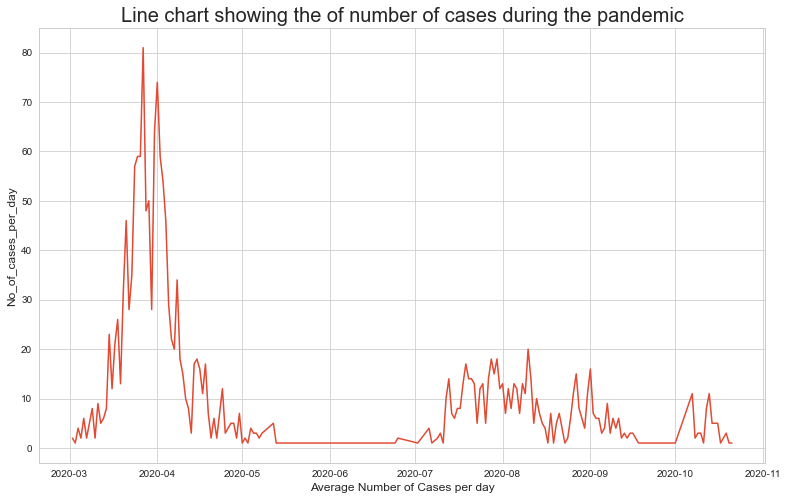

In [110]:
plt.figure(figsize=(13,8))
plt.title("Line chart showing the of number of cases during the pandemic", fontsize=20)
sns.lineplot(x='date', y='No_of_cases_per_day' ,data=covid_df,sort=False,ci=False) 
plt.xlabel("Average Number of Cases per day")
plt.show()

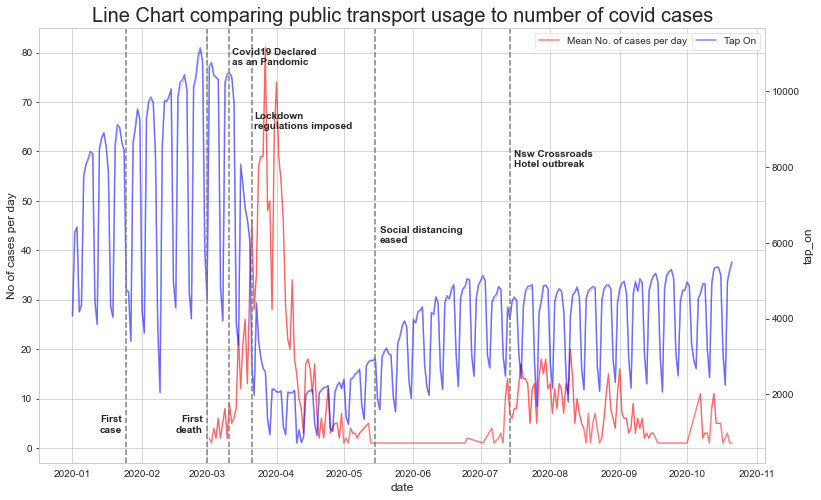

In [92]:
plt.figure(figsize=(13,8))
plt.title("Line Chart comparing public transport usage to number of covid cases", fontsize=20)
sns.lineplot(x='date', y='No of cases per day',alpha=0.5,data=covid_df,sort=False,ci=False,legend="full", label="Mean No. of cases per day                         ", color="red") 
ax2 = plt.twinx()
sns.lineplot(x='date', y=opal_df.tap_on,data=opal_df,ci=False,label="Tap On",color="blue",alpha=0.5) 
ax2.grid(None)
plt.text('2020-01-23', 1000, "First\ncase",fontweight='bold',ha='right')
plt.text('2020-02-28', 1000, "First\ndeath",fontweight='bold',ha='right')
plt.text('2020-03-12', 10700, "Covid19 Declared\nas an Pandomic",fontweight='bold',ha='left')
plt.text('2020-03-22', 9000, "Lockdown\nregulations imposed",fontweight='bold',ha='left')
plt.text('2020-05-17', 6000, "Social distancing\neased",fontweight='bold',ha='left')
plt.text('2020-07-16', 8000, "Nsw Crossroads\nHotel outbreak",fontweight='bold',ha='left')
plt.axvline(x='2020-01-25', linestyle='--',color='gray')
plt.axvline(x='2020-03-11', linestyle='--',color='gray')
plt.axvline(x='2020-03-01', linestyle='--',color='gray')
plt.axvline(x='2020-03-21', linestyle='--',color='gray')
plt.axvline(x='2020-05-15', linestyle='--',color='gray')        
plt.axvline(x='2020-07-14', linestyle='--',color='gray')        
plt.show()

From this graph we can see how the usage of transport started to drasticaly decline when Covid 19 was declared as a pandomic by WHO on the 11th of March. Usage of public transport further declined due to the enforcement of social distancing rules, closing of borders and the closing of schools to the the end of march. 

It is intresting to note how the number of covid cases lead to decrease within a few days after Lockdown regulations being enforced. The Social Distancing rules for NSW where only eased when the number of cases per day has reached a constant minimum. The use of public trnasport also has started increasing with the reduction in covid cases per day.

#### Analysing the number of coronavirus cases and use of public transport for Chatswood, Macquarie Park, North Sydney, Parramatta, Strathfield, Sydney CBD

In [102]:
print("District Names in covid df:")
print(covid_df['health_district_name'].unique(),"\n")
print("Local Gov names in covid df:")
print(covid_df['local_gov_name'].unique(),"\n")
print("Region Names in opal:")
print(opal_df['region'].unique())

District Names in covid df:
['Northern Sydney' 'Sydney' 'Western Sydney' nan 'South Western Sydney'
 'South Eastern Sydney' 'Nepean Blue Mountains' 'Central Coast'
 'Hunter New England' 'Mid North Coast' 'Western NSW' 'Northern NSW'
 'Illawarra Shoalhaven' 'Southern NSW' 'Murrumbidgee' 'Far West'
 'Network with Vic'] 

Local Gov names in covid df:
['Ku-ring-gai (A)' 'Hornsby (A)' 'Ryde (C)' 'Sydney (C)'
 'Northern Beaches (A)' 'Parramatta (C)' 'Cumberland (A)' nan
 'Fairfield (C)' 'Woollahra (A)' 'Canada Bay (A)' 'Blacktown (C)'
 'Willoughby (C)' 'Inner West (A)' 'Penrith (C)' 'Hunters Hill (A)'
 'Bayside (A)' 'Central Coast (C) (NSW)' 'Liverpool (C)' 'Hawkesbury (C)'
 'Georges River (A)' 'North Sydney (A)' 'Cessnock (C)' 'Waverley (A)'
 'The Hills Shire (A)' 'Randwick (C)' 'Lake Macquarie (C)'
 'Coffs Harbour (C)' 'Canterbury-Bankstown (A)' 'Lane Cove (A)'
 'Mid-Coast (A)' 'Newcastle (C)' 'Orange (C)' 'Camden (A)' 'Tweed (A)'
 'Sutherland Shire (A)' 'Shoalhaven (C)' 'Blue Mountains (C

#### Asummptions
* Will be using Hornsby since Macquarie park is not presnet in covid date and Hornsby is the closest.  
* Will be using Ku-ring-gai for chatswood since chatswood is not present in covid data and Ku-ring-gai is the closest

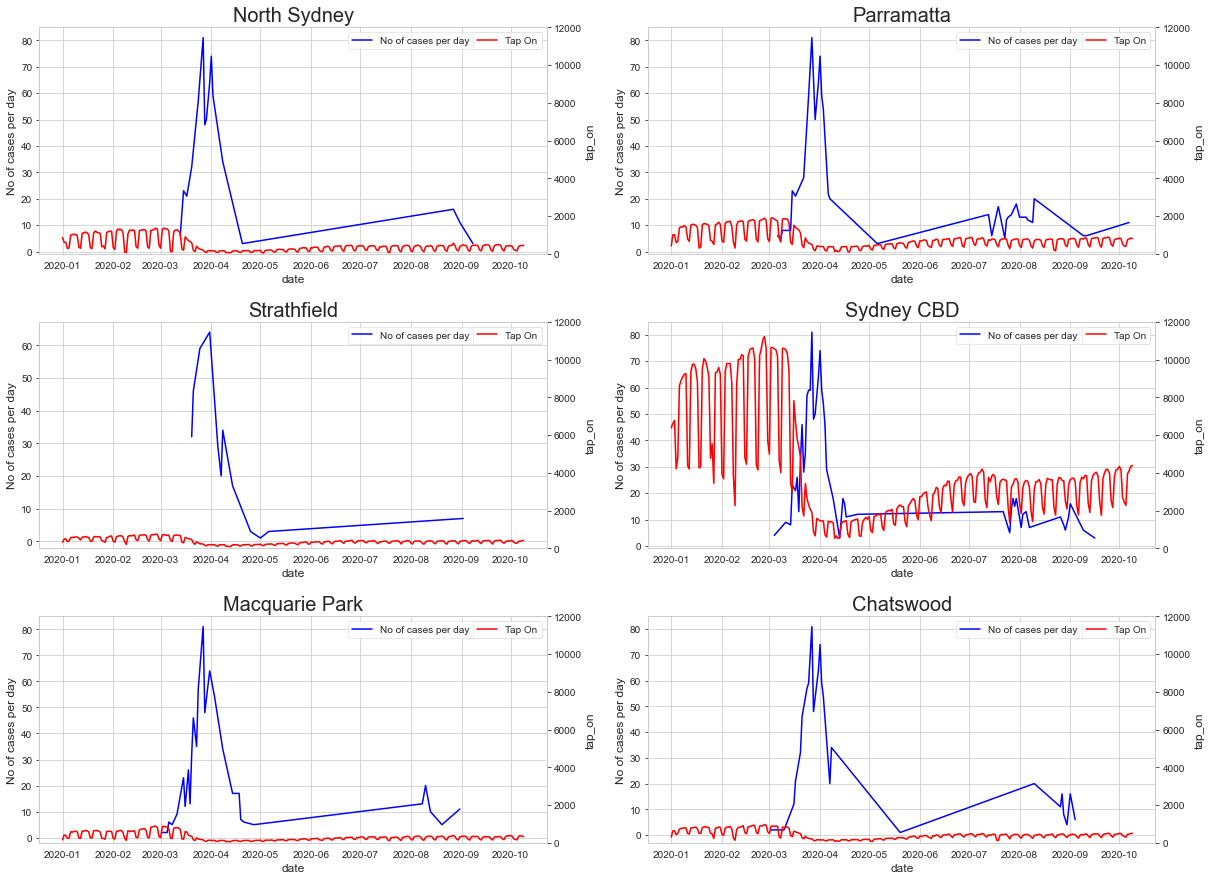

In [120]:
plt.figure(figsize=(20,15))
regions=['North Sydney','Parramatta','Strathfield','Sydney CBD','Macquarie Park','Chatswood']
govNames=['North Sydney (A)','Parramatta (C)','Strathfield (A)','Sydney (C)','Hornsby (A)','Ku-ring-gai (A)']
for i in range (1,7):
    plt.subplot(3, 2, i)
    mask1=opal_df['region'].isin([regions[i-1]])
    mask2=covid_df['local_gov_name'].isin([govNames[i-1]])
    opal_selected=opal_df[mask1]
    covid_selected=covid_df[mask2]
    plt.title(regions[i-1], fontsize=20)
    sns.lineplot(x='date', y='No of cases per day',data=covid_selected,sort=False,ci=False,legend="full", label="No of cases per day                         ", color="blue") 
    ax2 = plt.twinx()
    sns.lineplot(x='date', y='tap_on',data=opal_selected, sort=False,ci=False,label="Tap On",color="red") 
    plt.ylim(0, 12000)
    ax2.grid(None)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
plt.show()

In [122]:
mask1=covid_df['local_gov_name'].isin(['North Sydney (A)','Parramatta (C)','Strathfield (A)','Sydney (C)','Hornsby (A)','Ku-ring-gai (A)'])
covid_selected=covid_df[mask1]
mask1=opal_df['region'].isin(['North Sydney','Parramatta','Strathfield','Sydney CBD','Macquarie Park','Chatswood'])
opal_selected=opal_df[mask1]

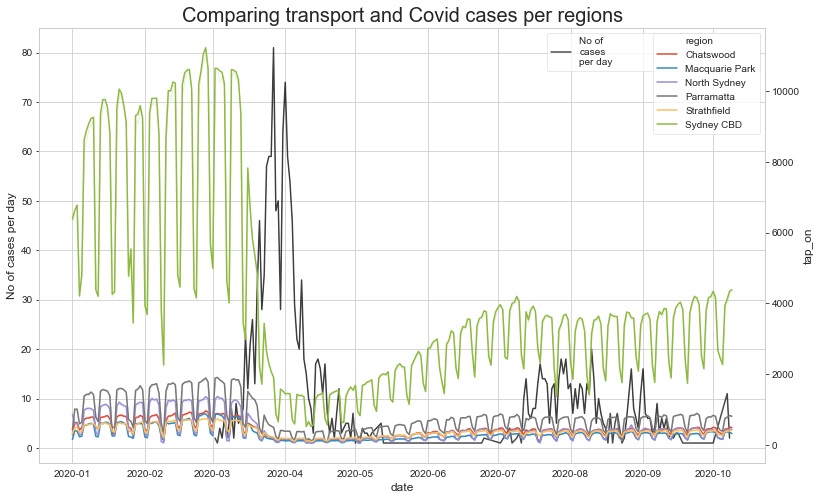

In [131]:
plt.figure(figsize=(13,8))
plt.title("Comparing transport and Covid cases per regions", fontsize=20)
sns.lineplot(x='date', y='No of cases per day',alpha=0.7,data=covid_df,ci=False,legend="full", label="No of\ncases\nper day                                                    ", color="black") 
fig.legend(loc="upper right")
ax2 = plt.twinx()
sns.lineplot(x='date', y='tap_on',data=opal_selected,hue='region',ci=False,color="blue") 
ax2.grid(None)

From the above graphs we can see that Sydney CBD has had the highest impact in the deacrease of public transport usage compared to other places. This could be mainly due to the vast amount of people traveling to it for economical purposes.

Also we can see that Strathfield has had the least number of Covid cases reported